In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions

def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)

def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interpolate_all(gridded_radar, tinterp_intv, base_field_name='reflectivity_masked'):
    # Get list of intervals in seconds between subsequent radar times
    tdiffs = gridded_radar['time_seconds'].diff(dim='time')
    
    # This list will hold all the time-interpolated grids (xarray Datasets). 
    # Can later be concatenated into a new xarray Dataset containing all times
    gridded_radar_interp_list = []
    
    # Grab first time from full dataset and restore singular time dimension
    first_time_ds = gridded_radar.isel(time=0)
    first_time_ds = first_time_ds.expand_dims(dim='time')

    gridded_radar_interp_list.append(first_time_ds)
    
#     tbgn = first_time_ds.coords['time_seconds'].values.item()  # Need to get scalar value, not 0-d
#                                                                # numpy array
    
    # Loop through the gridded_radar times, perform advection correction/interpolation between successive times
    # and add each to the list, making sure the time coordinate is consistent
    # new_time = tbgn
    for i, tdiff in enumerate(tdiffs.values):
        gridded_radar_interp_sublist = advection_correction_ds(gridded_radar.isel(time=slice(i, i+2)), 
                                                               tdiff, tinterp_intv, 
                                                               base_field_name=base_field_name)
        for t, gridded_radar_interp in enumerate(gridded_radar_interp_sublist):
#             new_time = new_time + tinterp_intv
#             new_ds = first_time_ds.copy()
#             new_ds[:] = gridded_radar_interp
#             new_ds.coords['time'] = new_ds['time'] + np.timedelta64(int(new_time), 's')
#             new_ds.coords['time_seconds'] = new_time
            gridded_radar_interp_list.append(gridded_radar_interp)
    
    return gridded_radar_interp_list


def advection_correction_ds(radar_ds, tintv_obs, tintv, base_field_name='reflectivity_masked', method="LK"):
    # Evaluate advection
    oflow_method = motion.get_method(method)
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects

    base_field = radar_ds[base_field_name]
    oflow_field = oflow_method(base_field, fd_kwargs=fd_kwargs)
    
    # Perform temporal interpolation on all variables in Dataset using the flow field derived from the "base"
    # field (by default, reflectivity)
    
    tbgn = base_field[0].coords['time_seconds'].values.item()   # Need to get scalar value, not 0-d
                                                                # numpy array
    print(tbgn)
    print(tintv)
    radar_ds_list = []
    x, y = np.meshgrid(
        np.arange(base_field[0].shape[1], dtype=float), np.arange(base_field[0].shape[0], dtype=float),
    )
    
    new_time = tbgn
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        new_time = new_time + tintv
        
        pos1 = (y - i / tintv_obs * oflow_field[1], x - i / tintv_obs * oflow_field[0])
        pos2 = (y + (tintv_obs - i) / tintv_obs * oflow_field[1], 
                x + (tintv_obs - i) / tintv_obs * oflow_field[0])
        
        field_interp_list = []
        for field_name, field_da in radar_ds.items():
            fieldt1 = map_coordinates(field_da[0], pos1, order=1)
            fieldt2 = map_coordinates(field_da[1], pos2, order=1)
       
            field_interp = field_da.isel(time=[0]).copy()
            field_interp[:] = ((tintv_obs - i) * fieldt1 + i * fieldt2) / tintv_obs
            try:
                field_interp.coords['time'] = field_interp['time'] + np.timedelta64(int(new_time - tbgn), 's')
            except TypeError:
                field_interp.coords['time'] = field_interp['time'] + timedelta(seconds=int(new_time - tbgn))
            field_interp.coords['time_seconds'] = new_time
            field_interp_list.append(field_interp)
        
        radar_ds_interp = xr.merge(field_interp_list)
        radar_ds_list.append(radar_ds_interp)
        
    return radar_ds_list


def advection_correction(arr, tintv_obs, tintv):
    """
    R = np.array([qpe_previous, qpe_current])
    T = time between two observations (5 min)
    t = interpolation timestep (1 min)
    """

    # Evaluate advection
    oflow_method = motion.get_method("LK")
    fd_kwargs = {"buffer_mask": 10}  # avoid edge effects
    V = oflow_method(arr, fd_kwargs=fd_kwargs)

    # Perform temporal interpolation
    # arr_d = np.zeros((arr[0].shape))
    arr_list = []
    x, y = np.meshgrid(
        np.arange(arr[0].shape[1], dtype=float), np.arange(arr[0].shape[0], dtype=float),
    )
    for i in np.arange(tintv, tintv_obs + tintv, tintv):

        pos1 = (y - i / tintv_obs * V[1], x - i / tintv_obs * V[0])
        R1 = map_coordinates(arr[0], pos1, order=1)
        
        pos2 = (y + (tintv_obs - i) / tintv_obs * V[1], x + (tintv_obs - i) / tintv_obs * V[0])
        R2 = map_coordinates(arr[1], pos2, order=1)

        arr_interp = ((tintv_obs - i) * R1 + i * R2) / tintv_obs
        arr_list.append(arr_interp)

    return arr_list

In [3]:
# Read in the gridded radar data

# For 04/30 case
# radar_name = 'KHTX'
# radar_type= 'NEXRAD'
# date = '0430'
# radar_start_datetimestamp = '20170430190000'
# radar_end_datetimestamp = '20170430235959'

# For 03/27 case
# radar_name = 'KGWX'
# radar_type= 'NEXRAD'
# date = '0327'
# radar_start_datetimestamp = '20170327190000'
# radar_end_datetimestamp = '20170327220000'

# For 03/27 case (deployment 2)
radar_name = 'KGWX'
radar_type= 'NEXRAD'
date = '0328'
radar_start_datetimestamp = '20170328000000'
radar_end_datetimestamp = '20170328040000'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/IOP_1B'
# FIXME: need to standardize naming of radar data directories
# radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
gridded_radar_dir = os.path.join(radar_basedir, 'gridded_new')
gridded_radar_output_dir = os.path.join(radar_basedir, 'gridded_dtd_040721')
if not os.path.exists(gridded_radar_output_dir):
    os.makedirs(gridded_radar_output_dir)

radar_start_timestamp = datetime_start.strftime('%H%M%S')
radar_end_timestamp = datetime_end.strftime('%H%M%S')
gridded_radar_combined_filename = '{}_{}_{}_gridded.nc'.format(radar_name, radar_start_timestamp,
                                                               radar_end_timestamp)

gridded_radar_combined_filepath = os.path.join(gridded_radar_dir, gridded_radar_combined_filename)
gridded_radar_combined_output_filepath = os.path.join(gridded_radar_output_dir, gridded_radar_combined_filename)
if os.path.exists(gridded_radar_combined_output_filepath):
    # Read in file since we already dumped it out in a previous run of the notebook
    gridded_radar_xr = xr.load_dataset(gridded_radar_combined_output_filepath)
else:
    # Read in individual gridded radar volumes, stack them into a combined Dataset and dump to disk
    # FIXME: the following doesn't work if the deployment straddles 0000 UTC!
    gridded_radar_paths = glob.glob(gridded_radar_dir + '/{}2017{}_*V06_gridded.nc'.format(radar_name, date))
    gridded_radar_paths = sorted(gridded_radar_paths)
    gridded_radar_input_list = []
    for path in gridded_radar_paths:
        filename = os.path.basename(path)
        file_timestamp = filename[4:19]
        file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
        if file_datetime >= datetime_start and file_datetime <= datetime_end:
            gridded_radar_input_list.append(path)
    gridded_radar_list = []
    gridded_radar_xr_list = []
    for gridded_radar_path in gridded_radar_input_list:
        print("Reading {}".format(os.path.basename(gridded_radar_path)))
        gridded_radar = pyart.io.read_grid(gridded_radar_path)
        gridded_radar_xr = gridded_radar.to_xarray()
        gridded_radar_xr_list.append(gridded_radar_xr)
    gridded_radar_xr = xr.concat(gridded_radar_xr_list, dim='time')
    print("Writing {}".format(gridded_radar_combined_filename))
    gridded_radar_xr.to_netcdf(gridded_radar_combined_output_filepath)

print(gridded_radar_xr)

<xarray.Dataset>
Dimensions:                    (time: 49, x: 247, y: 247, z: 41)
Coordinates:
  * time                       (time) datetime64[ns] 2017-03-28T00:03:51.4070...
  * z                          (z) float64 500.0 600.0 700.0 ... 4.4e+03 4.5e+03
    lat                        (y) float64 32.78 32.79 32.8 ... 34.98 34.99 35.0
    lon                        (x) float64 -89.64 -89.63 ... -87.02 -87.01
  * y                          (y) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
Data variables:
    differential_reflectivity  (time, z, y, x) float32 nan nan ... 0.02946
    reflectivity               (time, z, y, x) float32 nan nan ... 17.71 16.66
    cross_correlation_ratio    (time, z, y, x) float32 nan nan ... 0.9921 0.9938
    ROI                        (time, z, y, x) float32 4.58e+03 ... 4.78e+03


In [4]:
plot_dir = '/Users/dawson29/Dropbox/Students/Marcus_Terrell/plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
# Check to see if masked versions of reflectivity and differential reflectivity exist in the file. 
# If not, create them here.
ZH_thresh = 5.
ZDR_thresh = 0.1

print("Z and ZDR thresholds are {:f} and {:f}".format(ZH_thresh, ZDR_thresh))

if 'reflectivity_masked' not in gridded_radar_xr:
    print("Masking Z and ZDR on thresholds of {:f} and {:f}".format(ZH_thresh, ZDR_thresh))
    ZH_mask = np.where(gridded_radar_xr['reflectivity'] < ZH_thresh, True, False)
    ZH_mask = np.where(np.isfinite(gridded_radar_xr['reflectivity']), ZH_mask, False)
    ZDR_mask = np.where(gridded_radar_xr['differential_reflectivity'] < ZDR_thresh, True, False)
    ZDR_mask = np.where(np.isfinite(gridded_radar_xr['differential_reflectivity']), ZDR_mask, False)
    full_mask = np.ma.mask_or(ZH_mask, ZDR_mask)

    gridded_radar_xr['reflectivity_masked'] = gridded_radar_xr['reflectivity'].where(~full_mask)
    gridded_radar_xr['differential_reflectivity_masked'] = \
        gridded_radar_xr['differential_reflectivity'].where(~full_mask)
    print("Writing {}".format(gridded_radar_combined_filename))
    gridded_radar_xr.to_netcdf(gridded_radar_combined_output_filepath)
print(gridded_radar_xr)

Z and ZDR thresholds are 5.000000 and 0.100000
Masking Z and ZDR on thresholds of 5.000000 and 0.100000
Writing KGWX_000000_040000_gridded.nc
<xarray.Dataset>
Dimensions:                           (time: 49, x: 247, y: 247, z: 41)
Coordinates:
  * time                              (time) datetime64[ns] 2017-03-28T00:03:...
  * z                                 (z) float64 500.0 600.0 ... 4.5e+03
    lat                               (y) float64 32.78 32.79 ... 34.99 35.0
    lon                               (x) float64 -89.64 -89.63 ... -87.01
  * y                                 (y) float64 -1.23e+05 ... 1.23e+05
  * x                                 (x) float64 -1.23e+05 ... 1.23e+05
Data variables:
    differential_reflectivity         (time, z, y, x) float32 nan ... 0.02946
    reflectivity                      (time, z, y, x) float32 nan nan ... 16.66
    cross_correlation_ratio           (time, z, y, x) float32 nan nan ... 0.9938
    ROI                               (time, z, 

In [24]:
# Read in PIPS data (just to get lat/lon for now)
deployment = 'IOP1B_D2_2017'
PIPS_list = ['PIPS1A', 'PIPS1B', 'PIPS2B']
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'

PIPS_locs = []

for PIPS in PIPS_list:
    PIPS_filename = 'parsivel_combined_{}_{}_60s.nc'.format(deployment, PIPS)
    PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
    PIPS_ds = xr.load_dataset(PIPS_filepath)
    PIPS_loc = eval(PIPS_ds.location)
    PIPS_locs.append(PIPS_loc)

In [8]:
datetime_substart = datetime_start
datetime_subend = datetime_end
timestamp_substart = datetime_substart.strftime('%Y-%m-%dT%H:%M')
timestamp_subend = datetime_subend.strftime('%Y-%m-%dT%H:%M')

gridded_radar_xr_subset = gridded_radar_xr.sel(time=slice(timestamp_substart, timestamp_subend))
print(gridded_radar_xr_subset['time'])

# Round times to nearest minute
rounded_times = gridded_radar_xr_subset['time'].dt.round('60S')
print(rounded_times)
gridded_radar_xr_subset['time'] = rounded_times

time_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]) / np.timedelta64(1, 's')
print(time_seconds)
gridded_radar_xr_subset.coords['time_seconds'] = ('time', time_seconds)
print(gridded_radar_xr_subset)
# total_seconds = (gridded_radar_xr_subset['time'] - gridded_radar_xr_subset['time'][0]).total_seconds()

<xarray.DataArray 'time' (time: 49)>
array(['2017-03-28T00:03:51.407000000', '2017-03-28T00:07:50.407000000',
       '2017-03-28T00:11:48.407000000', '2017-03-28T00:17:57.407000000',
       '2017-03-28T00:21:56.407000000', '2017-03-28T00:25:54.407000000',
       '2017-03-28T00:29:53.407000000', '2017-03-28T00:33:53.407000000',
       '2017-03-28T00:37:53.407000000', '2017-03-28T00:41:58.407000000',
       '2017-03-28T00:46:30.407000000', '2017-03-28T00:50:50.407000000',
       '2017-03-28T00:54:55.407000000', '2017-03-28T00:59:14.407000000',
       '2017-03-28T01:03:26.407000000', '2017-03-28T01:07:26.407000000',
       '2017-03-28T01:11:38.407000000', '2017-03-28T01:15:49.407000000',
       '2017-03-28T01:20:02.407000000', '2017-03-28T01:24:33.407000000',
       '2017-03-28T01:29:05.407000000', '2017-03-28T01:33:38.407000000',
       '2017-03-28T01:38:10.407000000', '2017-03-28T01:42:55.407000000',
       '2017-03-28T01:47:55.407000000', '2017-03-28T01:52:41.407000000',
       '2017-0

In [9]:
# Extract one level from the gridded radar Dataset
height = 1000.
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset.sel(z=height).squeeze()
gridded_radar_xr_subset_onelevel = gridded_radar_xr_subset_onelevel.transpose("time", "y", "x")

Pysteps configuration file found at: /Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pysteps/pystepsrc

(2, 247, 247)
4.0897634249776145 0.4000753974488669


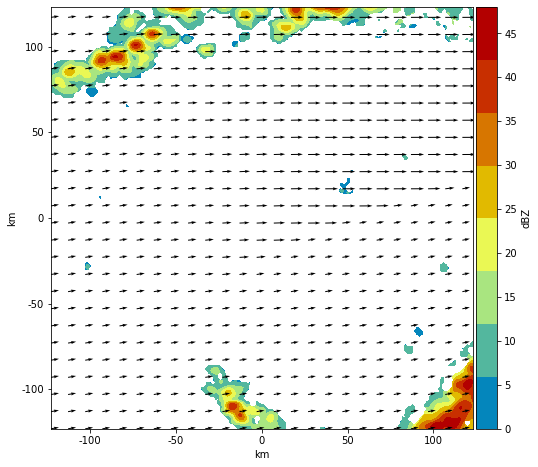

In [10]:
# Use pysteps for advection correction and temporal interpolation
from pysteps import io, motion, rcparams
from scipy.ndimage import map_coordinates

oflow_method = motion.get_method("LK")
fd_kwargs = {"buffer_mask": 10} # avoid edge effects

# Plot example of optical flow field
dBZ = gridded_radar_xr_subset_onelevel['reflectivity_masked']
# print(dBZ[0])
velocity_field = oflow_method(dBZ[11:13], fd_kwargs=fd_kwargs)

qintv = 10
xplt = gridded_radar_xr_subset_onelevel['x']
yplt = gridded_radar_xr_subset_onelevel['y']
uplt = velocity_field[0]
vplt = velocity_field[1]
print(velocity_field.shape)
fig, ax = plt.subplots(figsize=(8, 8))
clevels = np.arange(0., 61., 1.)
dBZ = ax.contourf(xplt, yplt, dBZ[11], clevels=clevels, cmap='pyart_HomeyerRainbow')
ax.quiver(xplt[::qintv], yplt[::qintv], uplt[::qintv,::qintv], vplt[::qintv,::qintv])
cbarintv = 5.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(dBZ, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dBZ')
formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(base=axestickintv))
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

plot_filename='pysteps_adv_correction_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

print(uplt.mean(), vplt.mean())

In [11]:
# Perform advection correction and interpolate gridded radar sequence to 1-min intervals
# Just do Z and ZDR

gridded_Z_ZDR = gridded_radar_xr_subset_onelevel[['reflectivity_masked', 'differential_reflectivity_masked']]
tinterp_intv = 60.

print(gridded_Z_ZDR)

# print(gridded_Z_ZDR.isel(time=[0]))

# for varname, var in gridded_Z_ZDR.items():
#     print(varname)
#     print(var[1])

gridded_Z_ZDR_interp_list = interpolate_all(gridded_Z_ZDR, tinterp_intv, 
                                            base_field_name='reflectivity_masked')


<xarray.Dataset>
Dimensions:                           (time: 49, x: 247, y: 247)
Coordinates:
  * time                              (time) datetime64[ns] 2017-03-28T00:04:...
    z                                 float64 1e+03
    lat                               (y) float64 32.78 32.79 ... 34.99 35.0
    lon                               (x) float64 -89.64 -89.63 ... -87.01
  * y                                 (y) float64 -1.23e+05 ... 1.23e+05
  * x                                 (x) float64 -1.23e+05 ... 1.23e+05
    time_seconds                      (time) float64 0.0 240.0 ... 1.362e+04
Data variables:
    reflectivity_masked               (time, y, x) float32 nan nan ... 19.32
    differential_reflectivity_masked  (time, y, x) float32 nan nan ... 0.1369
0.0
60.0
240.0
60.0
480.0
60.0
840.0
60.0
1080.0
60.0
1320.0
60.0
1560.0
60.0
1800.0
60.0
2040.0
60.0
2280.0
60.0
2580.0
60.0
2820.0
60.0
3060.0
60.0
3300.0
60.0
3540.0
60.0
3780.0
60.0
4080.0
60.0
4320.0
60.0
4560.0
60.0
4860

In [12]:
gridded_Z_ZDR_interp_ds = xr.concat(gridded_Z_ZDR_interp_list, 'time')
print(gridded_Z_ZDR_interp_ds)

<xarray.Dataset>
Dimensions:                           (time: 228, x: 247, y: 247)
Coordinates:
  * time                              (time) datetime64[ns] 2017-03-28T00:04:...
    z                                 float64 1e+03
    lat                               (y) float64 32.78 32.79 ... 34.99 35.0
    lon                               (x) float64 -89.64 -89.63 ... -87.01
  * y                                 (y) float64 -1.23e+05 ... 1.23e+05
  * x                                 (x) float64 -1.23e+05 ... 1.23e+05
    time_seconds                      (time) float64 0.0 60.0 ... 1.362e+04
Data variables:
    reflectivity_masked               (time, y, x) float32 nan nan ... nan nan
    differential_reflectivity_masked  (time, y, x) float32 nan nan ... nan nan


In [13]:
# Apply retrieval to get N0, alpha, and lamda
# at 1-min intervals.

In [14]:
# Set retrieval lookup table to use
retrieval_tag = 'Z01'
lookup_dir = os.path.join('/Users/dawson29/Projects/pyPIPS/data/lookups/', retrieval_tag)

# Retrieve gamma DSD parameters from ZH and ZDR
print("Getting ZH and ZDR fields")
# Get the ZH and ZDR fields from the xarray Dataset
ZH_rad = gridded_Z_ZDR_interp_ds['reflectivity_masked']
ZDR_rad = gridded_Z_ZDR_interp_ds['differential_reflectivity_masked']

# Read in first lookup table to get the interval between reflectivity and ZDR
lookup_path = os.path.join(lookup_dir, 'D0.csv')
retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
# Massage the index and column labels to get rid of extraneous zeros
# Also convert column labels from strings to floats
retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
retr_table.columns = [np.around(np.float(col), decimals=4) for col in retr_table.columns]

dBZ_lookup_min = retr_table.index[0]
dBZ_lookup_max = retr_table.index[-1]
ZDR_lookup_min = retr_table.columns[0]
ZDR_lookup_max = retr_table.columns[-1]
dBZ_intv = retr_table.index[1] - retr_table.index[0]
ZDR_intv = float(retr_table.columns[1]) - float(retr_table.columns[0])

# Replace masked entries in ZH_rad and ZDR_rad with the minimum value of the lookup table
ZH_mask = ZH_rad.isnull()
ZDR_mask = ZDR_rad.isnull()
full_mask = xr.where(ZH_mask | ZDR_mask, True, False)
ZH_rad = ZH_rad.fillna(dBZ_lookup_min)
ZDR_rad = ZDR_rad.fillna(ZDR_lookup_min)
# Now limit values to within lookup table limits
ZH_rad = ZH_rad.where(ZH_rad > dBZ_lookup_min, dBZ_lookup_min)
ZH_rad = ZH_rad.where(ZH_rad < dBZ_lookup_max, dBZ_lookup_max)
ZDR_rad = ZDR_rad.where(ZDR_rad > ZDR_lookup_min, ZDR_lookup_min)
ZDR_rad = ZDR_rad.where(ZDR_rad < ZDR_lookup_max, ZDR_lookup_max)
# Round ZH and ZDR fields to the nearest interval
ZH_round = roundPartial(ZH_rad, dBZ_intv)
ZDR_round = roundPartial(ZDR_rad, ZDR_intv)
# Get the shape of the arrays for later, so we can reshape the flattened arrays of retrieved
# values
ZH_shape = ZH_round.shape
print(ZH_shape)
ZH_flat = ZH_round.values.flatten()
ZDR_flat = ZDR_round.values.flatten()
print(ZH_flat.max())
print(ZDR_flat.max())

Getting ZH and ZDR fields
(228, 247, 247)
62.3
3.0


In [15]:
retr_var_da_dict = {}
for retr_varname in radar.retrieval_metadata.keys():
    print("Retrieving {} using lookup tables".format(retr_varname))
    lookup_path = os.path.join(lookup_dir, '{}.csv'.format(retr_varname))
    retr_table = pd.read_csv(lookup_path, sep=',', header=0, index_col='dBZ')
    # Round the indices and columns of the DataFrame (i.e. the dBZ values) to some sane
    # number of decimal places to facilitate using it as a lookup table. The floating point
    # precision gets in the way sometimes here. For example 56.4 is dumped out as
    # 56.4<some bunch of zeros>1
    retr_table.index = retr_table.index.to_series().apply(np.around, decimals=4)
    retr_table.columns = [np.around(np.float(col), decimals=4) for col in
                          retr_table.columns]
    # Gah, for some reason DataFrame.lookup sometimes barfs on perfectly good floating point
    # values in columns, so convert them back to strings here. :rolleyes:
    # EDIT 11/09/2020: Now this is happening for the rows as well. Not sure why... So change the row labels
    # to strings as well.
    retr_table.index = [str(row) for row in retr_table.index]
    retr_table.columns = [str(col) for col in retr_table.columns]
    # print(list(retr_table.index))
    # print(list(retr_table.columns))
    # Ok, now retrieve the desired retrieval variable
    # for each ZH/ZDR pair in the flattened radar sweep
#     for ZH, ZDR in zip(ZH_flat, ZDR_flat):
#         print(ZH, ZDR)
#         retr_val = retr_table.lookup([ZH.astype('str')], [ZDR.astype('str')])
    retr_vals = retr_table.lookup(ZH_flat.astype('str'), ZDR_flat.astype('str'))
    # retr_vals = retr_table.lookup(ZH_flat, ZDR_flat)
    # Reshape back to original shape
    retr_vals_data = retr_vals.reshape(ZH_shape)
    retr_vals_data = np.where(full_mask, np.nan, retr_vals_data)
    # retr_vals_data = np.ma.masked_array(retr_vals_data, mask=full_mask)
    retr_var_da = ZH_rad.copy()
    retr_var_da.name = retr_varname
    retr_var_da[:] = retr_vals_data
    retr_var_da_dict[retr_varname] = retr_var_da

Retrieving D0 using lookup tables
Retrieving Dm using lookup tables
Retrieving N0 using lookup tables
Retrieving Nt using lookup tables
Retrieving RR using lookup tables
Retrieving W using lookup tables
Retrieving lamda using lookup tables
Retrieving mu using lookup tables
Retrieving sigma using lookup tables


In [16]:
# Combine retrieved fields and Z and ZDR fields into a single Dataset
gridded_radar_interp_ds = gridded_Z_ZDR_interp_ds.copy()
for varname, var_da in retr_var_da_dict.items():
    gridded_radar_interp_ds[varname] = var_da
    
print(gridded_radar_interp_ds)

<xarray.Dataset>
Dimensions:                           (time: 228, x: 247, y: 247)
Coordinates:
  * time                              (time) datetime64[ns] 2017-03-28T00:04:...
    z                                 float64 1e+03
    lat                               (y) float64 32.78 32.79 ... 34.99 35.0
    lon                               (x) float64 -89.64 -89.63 ... -87.01
  * y                                 (y) float64 -1.23e+05 ... 1.23e+05
  * x                                 (x) float64 -1.23e+05 ... 1.23e+05
    time_seconds                      (time) float64 0.0 60.0 ... 1.362e+04
Data variables:
    reflectivity_masked               (time, y, x) float32 nan nan ... nan nan
    differential_reflectivity_masked  (time, y, x) float32 nan nan ... nan nan
    D0                                (time, y, x) float32 nan nan ... nan nan
    Dm                                (time, y, x) float32 nan nan ... nan nan
    N0                                (time, y, x) float32 nan na

In [18]:
# Save interpolated grid to file
out_start_timestamp = datetime_substart.strftime('%Y%m%d%H%M')
out_end_timestamp = datetime_subend.strftime('%Y%m%d%H%M')
gridded_radar_interp_filename = '{}_{}_{}_z{:d}_gridded_interp.nc'.format(radar_name, out_start_timestamp,
                                                                          out_end_timestamp, int(height))
gridded_radar_interp_filepath = os.path.join(gridded_radar_output_dir, gridded_radar_interp_filename)
gridded_radar_interp_ds.to_netcdf(gridded_radar_interp_filepath)

In [25]:
print(PIPS_locs)

[(34.859941678927576, -87.47583333333334, 205.74416380578714), (34.840500000000006, -87.36082960291802, 204.77241979607064), (34.81233333333334, -87.24933312390048, 205.29737371198794)]


In [26]:
# Find PIPS x, y location by interpolating to its lat/lon point
gridded_radar_interp_latlon_ds = gridded_radar_interp_ds.swap_dims({'x': 'lon', 'y': 'lat'})

radar_at_PIPS_list = []
PIPS_xy_list = []

for PIPS_loc in PIPS_locs:
    PIPS_lat = PIPS_loc[0]
    PIPS_lon = PIPS_loc[1]
    radar_at_PIPS_da = gridded_radar_interp_latlon_ds.interp(lat=PIPS_lat, lon=PIPS_lon)
    print(PIPS_lat, PIPS_lon)
    PIPS_x = radar_at_PIPS_da['x'].values.item()
    PIPS_y = radar_at_PIPS_da['y'].values.item()
    PIPS_xy = (PIPS_x, PIPS_y)
    PIPS_xy_list.append(PIPS_xy)
    print(PIPS_x, PIPS_y)
    radar_at_PIPS_list.append(radar_at_PIPS_da)


34.859941678927576 -87.47583333333334
79775.75695636043 107897.32403262504
34.840500000000006 -87.36082960291802
90527.38413910862 105735.18240578714
34.81233333333334 -87.24933312390048
100951.33044543209 102602.72068284621


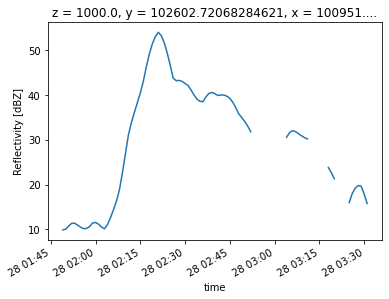

In [30]:
# Just some plotting stuff below here

radar_at_PIPS_list[2]['reflectivity_masked'].plot()

In [32]:
# Plot reflectivity for time-interpolated grid
# Choose a subset of times to keep animation size down
anim_start = '2017-03-28T02:00'
anim_end = '2017-03-28T03:00'

var_da = gridded_radar_interp_ds['reflectivity_masked'].sel(time=slice(anim_start, anim_end))

clevels =np.arange(0., 66., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=65.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    # Plot PIPS location
    for PIPS, PIPS_xy in zip(PIPS_list, PIPS_xy_list):
        PIPS_x = PIPS_xy[0]
        PIPS_y = PIPS_xy[1]
        ax.plot([PIPS_x], [PIPS_y], 'k*')
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
plt.close()
HTML(ani.to_jshtml())

In [ ]:
print(retr_var_da_dict.keys())

D0_da = retr_var_da_dict['D0']

clevels =np.arange(0., 6., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=6.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(8, 8))

ims = []
for i, var in enumerate(D0_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()

In [ ]:
from IPython.display import HTML

var_da = retr_var_da_dict['mu']

clevels =np.arange(0., 30., 1.)
norm = cm.colors.Normalize(vmin=0., vmax=30.)

import matplotlib.animation as animation
fig, ax = plt.subplots(figsize=(10, 10))

ims = []
for i, var in enumerate(var_da):
    time = var.coords['time_seconds'].values.item()
    ci = ax.contourf(xplt, yplt, var.squeeze(), 
                     levels=clevels, 
                     cmap='pyart_HomeyerRainbow', norm=norm)
    if i == 0.:
        fig.colorbar(ci, ax=ax)
        ax.set_aspect('equal')
    ims.append(ci.collections)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.close()
HTML(ani.to_jshtml())
# plt.show()